In [1]:
# 5/13 15:50 時点のコード

from collections import Counter
from bs4 import BeautifulSoup
import pandas as pd
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.metrics.pairwise import euclidean_distances

from scipy.spatial import Voronoi
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

/Users/temju/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/__init__.py:21: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy.sparse import issparse
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# CSVファイルのパスを指定して読み込む
df = pd.read_csv('wikiにある色のデータを全て集めたデータのデータにRGBのデータもつけたデータ.csv')

In [3]:
# 使わん列落とす
df = df.drop(columns=['色','名前','備考','マンセル']).dropna(subset=['R', 'G', 'B'])

In [4]:
# 「漢字・英語」と「同色・混同色」を結合しちゃう
df['名前'] = df.apply(lambda row: row['漢字・英語'] + '・' + row['同色・混同色'] 
                                            if pd.notna(row['同色・混同色']) else row['漢字・英語'], axis=1)
df = df.drop(columns=['漢字・英語','同色・混同色'])

# 行番号を連続的な整数値にリセットする
df.reset_index(drop=True, inplace=True)

In [5]:
# ・で区切られてた名前を集合にしたい
def create_name_set(text):
    names = text.split('・')
    return set(names)

In [6]:
# したったった
df['名前'] = df['名前'].apply(create_name_set)

In [7]:
print(df)

         R      G      B                   名前
0     93.0  129.0  101.0  {山葵色, almond green}
1     26.0   68.0  114.0      {紺青, iron blue}
2     15.0   84.0  116.0          {藍色, インディゴ}
3     94.0  124.0  133.0            {藍気鼠, 藍鼠}
4     71.0   81.0  137.0                {藍錆色}
..     ...    ...    ...                  ...
679  101.0  194.0  148.0                {若竹色}
680  171.0  200.0  139.0                {若葉色}
681  157.0  210.0  156.0                 {若緑}
682  166.0  199.0  142.0                {山葵色}
683  123.0  191.0  234.0   {フォゲットミーノット, 勿忘草色}

[684 rows x 4 columns]


In [8]:
# RGB列の組み合わせを文字列として追加
df['RGB_key'] = df['R'].astype(str) + '/' + df['G'].astype(str) + '/' + df['B'].astype(str)

# RGB_key列をキーとしてdfをグループ化します
grouped = df.groupby('RGB_key')

# 各グループ内の行番号のリスト
grouped_row_indices = grouped.apply(lambda x: x.index.tolist())

# 要素数が2以上のグループの行番号リストを抽出する
row_indices_with_multiple_occurrences = grouped_row_indices[grouped_row_indices.apply(len) >= 2]

# 結果
print(row_indices_with_multiple_occurrences)

RGB_key
0.0/105.0/86.0          [168, 404]
0.0/11.0/0.0            [444, 445]
0.0/111.0/134.0          [35, 644]
0.0/124.0/138.0         [137, 435]
0.0/174.0/149.0     [21, 339, 545]
                         ...      
90.0/185.0/193.0        [265, 317]
91.0/128.0/99.0         [152, 472]
92.0/59.0/84.0          [226, 613]
93.0/93.0/99.0          [335, 343]
94.0/124.0/133.0            [3, 7]
Length: 100, dtype: object


In [9]:
# 被ってるRGBの行を1つにしたい
# 草津に龍は二人もいらんねん

# 落とす行番号は格納していく
drop_list = []
# len(row_indices_with_multiple_occurrences)だけ走らせてー
for j in range(len(row_indices_with_multiple_occurrences)):
    name = df.iloc[row_indices_with_multiple_occurrences[j][0], 3]
    for k in range(1, len(row_indices_with_multiple_occurrences[j])):
        row_idx = row_indices_with_multiple_occurrences[j][k] # [137, 435, ...] の 435以降を取りたい
        name = name.union(df.iloc[row_idx, 3])
        drop_list.append(row_indices_with_multiple_occurrences[j][k])
    df.iloc[row_indices_with_multiple_occurrences[j][0], 3].update(name)
# さーつがいせよー
df = df.drop(drop_list)

# 改めてdfの行番号を連続的な整数値にリセット
df.reset_index(drop=True, inplace=True)

# RGB_keyはもはや不要
df = df.drop(columns=['RGB_key'])

In [10]:
df

,R,G,B,名前
0,93.0,129.0,101.0,"{山葵色, almond green}"
1,26.0,68.0,114.0,"{紺青, 狼色, Diesbach blue, bronze blue, プルシアンブルーほ..."
2,15.0,84.0,116.0,"{藍色, インディゴ}"
3,94.0,124.0,133.0,"{藍気鼠, 藍鼠}"
4,71.0,81.0,137.0,{藍錆色}
...,...,...,...,...
549,101.0,194.0,148.0,{若竹色}
550,171.0,200.0,139.0,{若葉色}
551,157.0,210.0,156.0,{若緑}
552,166.0,199.0,142.0,{山葵色}


In [11]:
df.to_csv('modified_df.csv', index=False)

In [12]:
# 全色座標化
coords_of_points = [(df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]) for i in range(len(df))]

In [13]:
# 始点集合からの距離の和を計算
def sum_of_distance_from_set(point,starting_origins):
    sum_d = 0
    origin_coords = [(df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]) for i in starting_origins]
    for origin in origin_coords:
        sum_d = sum_d + np.linalg.norm(np.array(point) - np.array(origin))
    return sum_d

In [14]:
# 与えられた点からの最大距離の点を計算
def farthest_point(point):
    distances = []
    point_coords = (df.iloc[point,0],df.iloc[point,1],df.iloc[point,2])
    for coord in coords_of_points:
        distances.append(np.linalg.norm(np.array(coord) - np.array(point_coords)))
    farthest_ind = np.argmax(distances)
    return farthest_ind

In [15]:
# 始点集合から最大距離の点を計算
# これいらんな
def farthest_from_set(point,starting_origins):
    distances = []
    origin_coords = [(df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]) for i in starting_origins]
    for origin in origin_coords:
        distances.append(np.linalg.norm(np.array(point) - np.array(origin)))
    farthest_ind = np.argmax(distances)
    return farthest_ind

In [16]:
def calculate_centroid(origin_points):
    # 点の数
    n = len(origin_points)
    
    # 各次元の合計を初期化
    sum_x = sum_y = sum_z = 0
    
    # 各点の座標の合計を計算
    for point in origin_points:
        sum_x += df.iloc[point,[0]][0]
        sum_y += df.iloc[point,[1]][0]
        sum_z += df.iloc[point,[2]][0]
    
    # 各次元の平均を計算
    centroid_x = sum_x / n
    centroid_y = sum_y / n
    centroid_z = sum_z / n
    
    # 重心を返す
    return (centroid_x, centroid_y, centroid_z)

In [17]:
# 始点から最小距離の点を計算
def closest_from_point(origin_point):
    distances = []
    origin_coord = (df.iloc[origin_point,0],df.iloc[origin_point,1],df.iloc[origin_point,2])
    for coord in coords_of_points:
        distances.append(np.linalg.norm(np.array(coord) - np.array(origin_point)))
    closest_ind = np.argmin(distances)
    return closest_ind

In [18]:
# 距離の和を使ってstarting_origins からの最遠点を求める
def farthest_by_sum(starting_origins):
    distances = []
    origin_coords = [(df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]) for i in starting_origins]
    for point in coords_of_points:
        distances.append(sum_of_distance_from_set(point,starting_origins))

    # 最も遠い点のインデックスを見つける
    farthest_point_index = -1
    max_distance = -1
    for i, distance in enumerate(distances):
        if i not in starting_origins and distance > max_distance:
            farthest_point_index = i
            max_distance = distance

    return farthest_point_index

In [19]:
# 重心を使ってstarting_origins からの最遠点を求める
def farthest_by_centroid(starting_origins):
    distances = []
    centroid = calculate_centroid(starting_origins)
    
    for coord in coords_of_points:
        distances.append(np.linalg.norm(np.array(coord) - np.array(centroid)))

    # 最も遠い点のインデックスを見つける
    farthest_point_index = -1
    max_distance = -1
    for i, distance in enumerate(distances):
        if i not in starting_origins and distance > max_distance:
            farthest_point_index = i
            max_distance = distance

    return farthest_point_index

In [20]:
# 半径を使ってstarting_origins からの最遠点を求める
# なぜかリストが返ってくるので[0][0]抜いてます
def farthest_by_radius(starting_origins):
    origin_coords = [(df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]) for i in starting_origins]

    # 中心とする円の半径の初期値
    radius = 0
    previous_outlier_points = []

    while True:
        # 含まれない点を保持するリスト
        outlier_points = []

        for center_point in origin_coords:
            for idx,point in enumerate(coords_of_points):
                
                # 中心点に含まれる点は除外する
                if point in origin_coords:
                    continue
                
                # 中心とする円の半径で円を定義し、点が円の内側に含まれるかどうかをチェック
                distance = np.linalg.norm(np.array(center_point) - np.array(point))
                if distance > radius:
                    outlier_points.append((idx,point))

        # 含まれない点が1つになったらループを終了
        if len(outlier_points) == 0:
            # 直前の半径で含まれていた点のインデックスを返す
            return previous_outlier_points
        
        # 含まれない点が1つになるまで、円の半径を拡大
        radius += 1
        
        # 直前の状態を保持
        previous_outlier_points = outlier_points

    return previous_outlier_points#[0][0]

In [21]:
# 距離の和を用いて最遠点を表示し，starting_originsに追加する
def new_origins_by_sum(starting_origins):
    farthest_ind = farthest_by_sum(starting_origins)
    starting_origins.append(farthest_ind)
    return print(df.iloc[farthest_ind])

In [22]:
# 重心を用いて最遠点を表示し，starting_originsに追加する
def new_origins_by_centroid(starting_origins):
    farthest_ind = farthest_by_centroid(starting_origins)
    starting_origins.append(farthest_ind)
    return print(df.iloc[farthest_ind])

In [23]:
# 半径のやつ使って最遠点を表示し，starting_originsに追加する
# 多分バグわいてるしここで[0][0]つけてる
def new_origins_by_radius(starting_origins):
    farthest_ind = farthest_by_radius(starting_origins)[0][0]
    starting_origins.append(farthest_ind)
    return print(df.iloc[farthest_ind])

In [24]:
# 与えられた点をplot
def plot_colors(points):

    # 点のリスト
    points_3d = [(df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]) for i in points]

    # プロット
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    # 点をプロット
    ax.scatter(*zip(*points_3d), color='blue', s=50)  # sで点の大きさを指定
    
    # 軸の範囲の設定
    ax.set_xlim([0, 260])
    ax.set_ylim([0, 260])
    ax.set_zlim([0, 260])

    # 軸ラベルの設定
    ax.set_xlabel('X軸')
    ax.set_ylabel('Y軸')
    ax.set_zlabel('Z軸')

    # グリッドの表示
    ax.grid(True)

    # 視点の調整
    ax.view_init(elev=30, azim=45)

    ax.set_title('Colors')

    return plt.show()

In [25]:
# とりあえず赤青緑はどこにおる
red_rows = df[df['名前'].apply(lambda x: '赤' in x)]
blue_rows = df[df['名前'].apply(lambda x: '青' in x)]
green_rows = df[df['名前'].apply(lambda x: '緑' in x)]
print(red_rows, blue_rows, green_rows) # ここっここー
#  535,454,492をベースの赤青緑として使用する

         R     G     B                    名前
22   237.0  26.0  61.0  {赤, 朱, 紅, レッド, 丹, 緋}
535  241.0  91.0  91.0              {赤, red}        R      G      B                 名前
12   0.0  103.0  192.0  {青, 藍, 蒼, ブルー, 碧}
454  0.0  125.0  197.0          {青, blue}        R      G      B          名前
190  0.0  177.0  107.0  {green, 緑}
492  0.0  128.0    0.0   {グリーン, 緑}
493  0.0  121.0   61.0      {緑, 翠}


In [26]:
# 基本色
# RGB違うのに被ってるのも多々ある
# とりあえず名前でまとめてみる

basic_color_names = ['青', '青緑', '青紫', '赤', '赤紫', '黄色', '黄緑', '黄赤', '黄黄色', '緑', '黒', 'cyancyan blue', '白', '紫', '灰色']
basic_colors = []
for name in basic_color_names:
    k= [i for i, names_set in enumerate(df['名前']) if name in names_set]
    print(name, ':', k)
    basic_colors.append(k)

青 : [12, 454]
青緑 : [20]
青紫 : [21, 396]
赤 : [22, 535]
赤紫 : [31]
黄色 : [62]
黄緑 : [64]
黄赤 : [65, 136]
黄黄色 : [167]
緑 : [190, 492, 493]
黒 : [196, 452]
cyancyan blue : [254]
白 : [277, 474]
紫 : [388, 499]
灰色 : [45, 194, 382, 395]


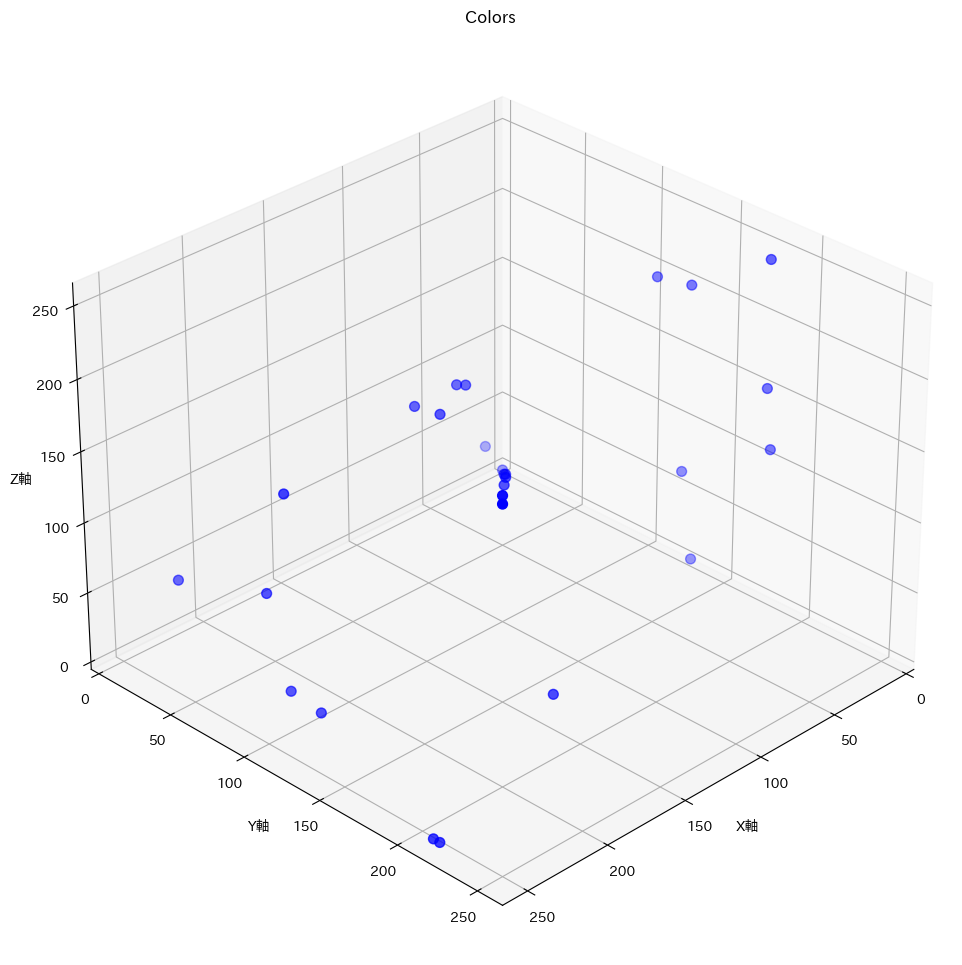

In [27]:
# 基本色のplot
# この散らばりが欲しい
basic_colors = [item for sublist in basic_colors for item in sublist]
plot_colors(basic_colors)

In [28]:
# 基本色達
for i in basic_colors:
    print(df.iloc[i])

R                   0.0
G                 103.0
B                 192.0
名前    {青, 藍, 蒼, ブルー, 碧}
Name: 12, dtype: object
R           0.0
G         125.0
B         197.0
名前    {青, blue}
Name: 454, dtype: object
R                                0.0
G                              174.0
B                              149.0
名前    {青緑, blue green, 青緑色, ブルーグリーン}
Name: 20, dtype: object
R                                  111.0
G                                   81.0
B                                  161.0
名前    {purple blue, 青紫, パープルブルー, バイオレット}
Name: 21, dtype: object
R                113.0
G                 89.0
B                166.0
名前    {violet, 菫色, 青紫}
Name: 396, dtype: object
R                    237.0
G                     26.0
B                     61.0
名前    {赤, 朱, 紅, レッド, 丹, 緋}
Name: 22, dtype: object
R        241.0
G         91.0
B         91.0
名前    {赤, red}
Name: 535, dtype: object
R                         240.0
G                         103.0
B                         166.0
名

In [29]:
# クラスタ数15でK平均法を適用
# ↑基本色が15色だから
kmeans = KMeans(n_clusters=15, random_state=0)
kmeans.fit(coords_of_points)

# クラスタの中心点を取得
cluster_centers = kmeans.cluster_centers_

# クラスタの中心点を表示(最近点で近似)
rep_points = []
for point in cluster_centers:
    rep_points.append(closest_from_point(point))
for point in rep_points:
    print(df.iloc[point])

R       23.0
G       91.0
B      102.0
名前    {熨斗目色}
Name: 384, dtype: object
R        228.0
G        192.0
B        104.0
名前    {bamboo}
Name: 410, dtype: object
R     124.0
G      64.0
B      46.0
名前    {赤褐色}
Name: 301, dtype: object
R                              243.0
G                              236.0
B                              216.0
名前    {象牙色, アイボリー, ivoryivory white}
Name: 8, dtype: object
R     151.0
G     167.0
B     145.0
名前    {深川鼠}
Name: 439, dtype: object
R     180.0
G     113.0
B      66.0
名前     {土色}
Name: 343, dtype: object
R     230.0
G     107.0
B      88.0
名前    {鉛丹色}
Name: 118, dtype: object
R         35.0
G         31.0
B         32.0
名前    {呂色, 蝋色}
Name: 538, dtype: object
R                           38.0
G                          124.0
B                          167.0
名前    {縹縹色, 中縹, 花田色, 花色, 縹, シアン}
Name: 366, dtype: object
R     151.0
G     195.0
B     208.0
名前     {薄藍}
Name: 82, dtype: object
R        226.0
G        174.0
B        168.0
名前    {退紅, 褪紅}
N

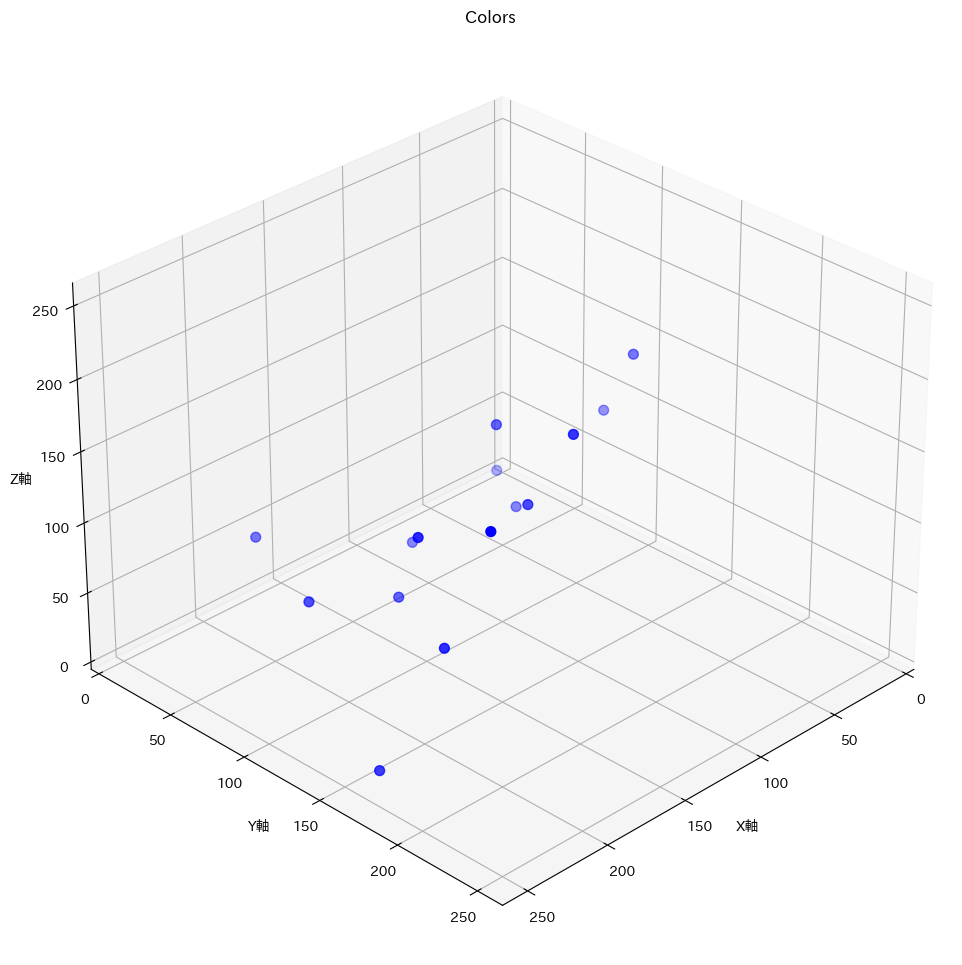

In [30]:
plot_colors(rep_points)

In [31]:
# 15のクラスタと各代表色を表示する
for i in rep_points:
    given_point = [df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]]
    cluster_index = kmeans.predict([given_point])

    print("与えられた点が属するクラスタ:", cluster_index[0],":",df.iloc[i][3])

与えられた点が属するクラスタ: 0 : {'熨斗目色'}
与えられた点が属するクラスタ: 1 : {'bamboo'}
与えられた点が属するクラスタ: 2 : {'赤褐色'}
与えられた点が属するクラスタ: 3 : {'象牙色', 'アイボリー', 'ivoryivory white'}
与えられた点が属するクラスタ: 4 : {'深川鼠'}
与えられた点が属するクラスタ: 5 : {'土色'}
与えられた点が属するクラスタ: 6 : {'鉛丹色'}
与えられた点が属するクラスタ: 7 : {'呂色', '蝋色'}
与えられた点が属するクラスタ: 8 : {'縹縹色', '中縹', '花田色', '花色', '縹', 'シアン'}
与えられた点が属するクラスタ: 9 : {'薄藍'}
与えられた点が属するクラスタ: 10 : {'退紅', '褪紅'}
与えられた点が属するクラスタ: 11 : {'紫苑色'}
与えられた点が属するクラスタ: 12 : {'山吹色', 'ゴールデンイエロー', '黄金色', 'イエローオレンジ', '黄橙'}
与えられた点が属するクラスタ: 13 : {'唐紅（韓紅', '韓紅花）', '紅色'}
与えられた点が属するクラスタ: 14 : {'利休生壁'}


In [32]:
# 基本色がどのクラスタに所属するかを調べる
for i in basic_colors:
    given_point = [df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]]
    cluster_index = kmeans.predict([given_point])

    print("与えられた点が属するクラスタ:", cluster_index[0],":",df.iloc[i][3])

与えられた点が属するクラスタ: 8 : {'青', '藍', '蒼', 'ブルー', '碧'}
与えられた点が属するクラスタ: 8 : {'青', 'blue'}
与えられた点が属するクラスタ: 8 : {'青緑', 'blue green', '青緑色', 'ブルーグリーン'}
与えられた点が属するクラスタ: 11 : {'purple blue', '青紫', 'パープルブルー', 'バイオレット'}
与えられた点が属するクラスタ: 11 : {'violet', '菫色', '青紫'}
与えられた点が属するクラスタ: 13 : {'赤', '朱', '紅', 'レッド', '丹', '緋'}
与えられた点が属するクラスタ: 6 : {'赤', 'red'}
与えられた点が属するクラスタ: 10 : {'赤紫', 'レッドパープル', 'red purple'}
与えられた点が属するクラスタ: 12 : {'jaune brillant', '黄色', 'yellow'}
与えられた点が属するクラスタ: 1 : {'yellow green', '黄緑', '黄緑色', 'イエローグリーン'}
与えられた点が属するクラスタ: 6 : {'黄赤', 'yellow red', 'イエローレッド', 'オレンジ'}
与えられた点が属するクラスタ: 12 : {'orangeオレンジ色', '黄赤', '橙色', 'オレンジ'}
与えられた点が属するクラスタ: 12 : {'蒲公英色', '黄黄色', 'イエロー'}
与えられた点が属するクラスタ: 8 : {'green', '緑'}
与えられた点が属するクラスタ: 0 : {'グリーン', '緑'}
与えられた点が属するクラスタ: 0 : {'緑', '翠'}
与えられた点が属するクラスタ: 7 : {'ブラック', '黒'}
与えられた点が属するクラスタ: 7 : {'black', '黒'}
与えられた点が属するクラスタ: 8 : {'cyancyan blue', '藍紫色', 'シアン'}
与えられた点が属するクラスタ: 3 : {'白', 'ホワイト'}
与えられた点が属するクラスタ: 3 : {'白', 'white'}
与えられた点が属するクラスタ: 11 : {'紫', 'purple'}
与えられ

In [33]:
# どれぐらいのクラスタ数なら gray と purple や 青 と 青緑 を分類することができるのか?
# クラスタ数16ぐらいから始める

for n in range(16,31):
    
    print("クラスタ数 = ",n,"\n")
    
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(coords_of_points)

    # クラスタの中心点を取得
    cluster_centers = kmeans.cluster_centers_

    # クラスタの代表点
    rep_points = []
    for point in cluster_centers:
        rep_points.append(closest_from_point(point))

    # n個のクラスタと各代表色を表示する
    for i in rep_points:
        given_point = [df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]]
        cluster_index = kmeans.predict([given_point])

        print("与えられた点が属するクラスタ:", cluster_index[0],":",df.iloc[i][3])
    print("\n")

    # 基本色がどのクラスタに所属するかを調べる
    for i in basic_colors:
        given_point = [df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]]
        cluster_index = kmeans.predict([given_point])

        print("与えられた点が属するクラスタ:", cluster_index[0],":",df.iloc[i][3])
    print("\n")

クラスタ数 =  16 

与えられた点が属するクラスタ: 0 : {'深川鼠'}
与えられた点が属するクラスタ: 1 : {'赤褐色'}
与えられた点が属するクラスタ: 2 : {'縹縹色', '中縹', '花田色', '花色', '縹', 'シアン'}
与えられた点が属するクラスタ: 3 : {'薄藍'}
与えられた点が属するクラスタ: 4 : {'salmon pink'}
与えられた点が属するクラスタ: 5 : {'呂色', '蝋色'}
与えられた点が属するクラスタ: 6 : {'生成色', 'エクルベージュ'}
与えられた点が属するクラスタ: 7 : {'利休生壁'}
与えられた点が属するクラスタ: 8 : {'cadmium yellow'}
与えられた点が属するクラスタ: 9 : {'亜麻色', 'エクルベージュ'}
与えられた点が属するクラスタ: 10 : {'紫苑色'}
与えられた点が属するクラスタ: 11 : {'peach blossom', '桃色桃花色', 'ピーチブロッサム', '桃色', 'ピンク'}
与えられた点が属するクラスタ: 12 : {'熨斗目色'}
与えられた点が属するクラスタ: 13 : {'紅色', '韓紅花', '唐紅', '韓紅'}
与えられた点が属するクラスタ: 14 : {'bamboo'}
与えられた点が属するクラスタ: 15 : {'焦香'}


与えられた点が属するクラスタ: 2 : {'青', '藍', '蒼', 'ブルー', '碧'}
与えられた点が属するクラスタ: 2 : {'青', 'blue'}
与えられた点が属するクラスタ: 2 : {'青緑', 'blue green', '青緑色', 'ブルーグリーン'}
与えられた点が属するクラスタ: 10 : {'purple blue', '青紫', 'パープルブルー', 'バイオレット'}
与えられた点が属するクラスタ: 10 : {'violet', '菫色', '青紫'}
与えられた点が属するクラスタ: 13 : {'赤', '朱', '紅', 'レッド', '丹', '緋'}
与えられた点が属するクラスタ: 4 : {'赤', 'red'}
与えられた点が属するクラスタ: 11 : {'赤紫', 'レッドパープル', 'red purple'}

与えられた点が属するクラスタ: 7 : {'violet', '菫色', '青紫'}
与えられた点が属するクラスタ: 17 : {'赤', '朱', '紅', 'レッド', '丹', '緋'}
与えられた点が属するクラスタ: 5 : {'赤', 'red'}
与えられた点が属するクラスタ: 0 : {'赤紫', 'レッドパープル', 'red purple'}
与えられた点が属するクラスタ: 6 : {'jaune brillant', '黄色', 'yellow'}
与えられた点が属するクラスタ: 18 : {'yellow green', '黄緑', '黄緑色', 'イエローグリーン'}
与えられた点が属するクラスタ: 5 : {'黄赤', 'yellow red', 'イエローレッド', 'オレンジ'}
与えられた点が属するクラスタ: 5 : {'orangeオレンジ色', '黄赤', '橙色', 'オレンジ'}
与えられた点が属するクラスタ: 6 : {'蒲公英色', '黄黄色', 'イエロー'}
与えられた点が属するクラスタ: 14 : {'green', '緑'}
与えられた点が属するクラスタ: 12 : {'グリーン', '緑'}
与えられた点が属するクラスタ: 3 : {'緑', '翠'}
与えられた点が属するクラスタ: 12 : {'ブラック', '黒'}
与えられた点が属するクラスタ: 12 : {'black', '黒'}
与えられた点が属するクラスタ: 14 : {'cyancyan blue', '藍紫色', 'シアン'}
与えられた点が属するクラスタ: 4 : {'白', 'ホワイト'}
与えられた点が属するクラスタ: 4 : {'白', 'white'}
与えられた点が属するクラスタ: 2 : {'紫', 'purple'}
与えられた点が属するクラスタ: 7 : {'紫', 'パープル'}
与えられた点が属するクラスタ: 2 : {'ash grey', '灰色'}
与えられた点が属するクラスタ: 19 : {'灰色', 'gray, grey', '鼠色'}
与えられた点が属するクラスタ: 2 : {'鼠色', '灰色', 'グレー'}
与えられた点が属するクラスタ: 19 : {'灰色', '鼠色', 'グレー'}


クラスタ数

与えられた点が属するクラスタ: 0 : {'紅色', '韓紅花', '唐紅', '韓紅'}
与えられた点が属するクラスタ: 1 : {'薄鼠'}
与えられた点が属するクラスタ: 2 : {'橡色'}
与えられた点が属するクラスタ: 3 : {'萌葱色', '萌木色', '萌黄萌黄色'}
与えられた点が属するクラスタ: 4 : {'コーン', 'メイズ', '玉蜀黍色'}
与えられた点が属するクラスタ: 5 : {'山吹色', 'ゴールデンイエロー', '黄金色', 'イエローオレンジ', '黄橙'}
与えられた点が属するクラスタ: 6 : {'桧皮色', '檜皮色'}
与えられた点が属するクラスタ: 7 : {'縹縹色', '中縹', '花田色', '花色', '縹', 'シアン'}
与えられた点が属するクラスタ: 8 : {'東雲色', '曙色'}
与えられた点が属するクラスタ: 9 : {'江戸茶'}
与えられた点が属するクラスタ: 10 : {'sky gray'}
与えられた点が属するクラスタ: 11 : {'呂色', '蝋色'}
与えられた点が属するクラスタ: 12 : {'根岸色'}
与えられた点が属するクラスタ: 13 : {'薄香'}
与えられた点が属するクラスタ: 14 : {'horizon blue'}
与えられた点が属するクラスタ: 15 : {'chocolatechocolate brown'}
与えられた点が属するクラスタ: 16 : {'生成色', 'エクルベージュ'}
与えられた点が属するクラスタ: 17 : {'山鳩色', '青白橡', '麹塵'}
与えられた点が属するクラスタ: 18 : {'江戸紫'}
与えられた点が属するクラスタ: 19 : {'hunter green'}
与えられた点が属するクラスタ: 20 : {'藍色', 'インディゴ'}
与えられた点が属するクラスタ: 21 : {'牡丹色'}
与えられた点が属するクラスタ: 22 : {'青緑', 'blue green', '青緑色', 'ブルーグリーン'}
与えられた点が属するクラスタ: 23 : {'scarlet', '緋色'}
与えられた点が属するクラスタ: 24 : {'薄花色'}


与えられた点が属するクラスタ: 7 : {'青', '藍', '蒼

与えられた点が属するクラスタ: 0 : {'crimson'}
与えられた点が属するクラスタ: 1 : {'ダブグレイ', '鳩羽色', '鳩羽鼠'}
与えられた点が属するクラスタ: 2 : {'錆鼠'}
与えられた点が属するクラスタ: 3 : {'山葵色'}
与えられた点が属するクラスタ: 4 : {'Naples yellow'}
与えられた点が属するクラスタ: 5 : {'cadmium yellow'}
与えられた点が属するクラスタ: 6 : {'桧皮色', '檜皮色'}
与えられた点が属するクラスタ: 7 : {'青', 'blue'}
与えられた点が属するクラスタ: 8 : {'東雲色', '曙色'}
与えられた点が属するクラスタ: 9 : {'江戸茶'}
与えられた点が属するクラスタ: 10 : {'sky gray'}
与えられた点が属するクラスタ: 11 : {'青褐'}
与えられた点が属するクラスタ: 12 : {'根岸色'}
与えられた点が属するクラスタ: 13 : {'薄香'}
与えられた点が属するクラスタ: 14 : {'horizon blue'}
与えられた点が属するクラスタ: 15 : {'chocolatechocolate brown'}
与えられた点が属するクラスタ: 16 : {'生成色', 'エクルベージュ'}
与えられた点が属するクラスタ: 17 : {'山鳩色', '青白橡', '麹塵'}
与えられた点が属するクラスタ: 18 : {'江戸紫'}
与えられた点が属するクラスタ: 19 : {'hunter green'}
与えられた点が属するクラスタ: 20 : {'青藍'}
与えられた点が属するクラスタ: 21 : {'牡丹色'}
与えられた点が属するクラスタ: 22 : {'peacock blue'}
与えられた点が属するクラスタ: 23 : {'geranium red'}
与えられた点が属するクラスタ: 24 : {'浅縹'}
与えられた点が属するクラスタ: 25 : {'raw sienna'}
与えられた点が属するクラスタ: 26 : {'烏羽色', '濡烏', '濡羽色'}
与えられた点が属するクラスタ: 27 : {'萌葱色', '萌木色', '萌黄萌黄色'}
与えられた点が属するクラスタ: 28 : 

青と青緑はクラスタ数17で分けることができるが，  
purpleとash greyはぜんっぜん分けることができないマジで  
一応，クラスタ数17の時点でpurpleとパープルが分かれて，  
クラスタ数20でパープルとgrayが分かれ始めた．  

と，思ったら，なんか知らんけどクラスタ数21の時点で紫系統と灰色系統がめちゃくちゃ綺麗に分かれてる．  
でも青と青緑がくっついてる．

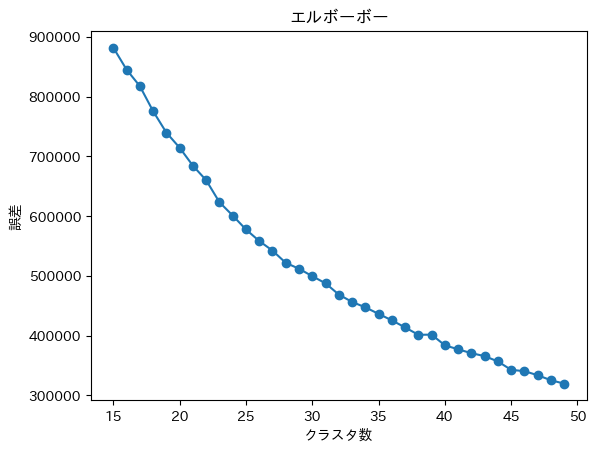

In [34]:
# エルボー法を用いて最適なクラスタ数を求めたい
# https://qiita.com/panda531/items/4b5504a3949eacb7ab19

# クラスタ数の範囲を定義
cluster_range = range(15, 50)

# 各クラスタ数でのクラスタ内誤差を保存するリスト
cluster_errors = []

# クラスタ数の範囲でK平均法を実行し、クラスタ内誤差を計算
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(coords_of_points)
    cluster_errors.append(kmeans.inertia_)  # inertia_はクラスタ内誤差を示す属性

# クラスタ内誤差のプロット
plt.plot(cluster_range, cluster_errors, marker='o')
plt.xlabel('クラスタ数')
plt.ylabel('誤差')
plt.title('エルボーボー')
plt.show()

全然あかんやん

In [35]:
# 和で最遠点を定義して何回か追加したらどうなるか
starting_origins = [535,454,492]
for n in range(20):
    print(n+1,'回目')
    new_origins_by_sum(starting_origins)

1 回目
R          255.0
G          255.0
B          251.0
名前    {白, white}
Name: 474, dtype: object
2 回目
R              243.0
G                1.0
B                0.0
名前    {hunting pink}
Name: 409, dtype: object
3 回目
R                0.0
G               11.0
B                0.0
名前    {烏羽色, 濡烏, 濡羽色}
Name: 377, dtype: object
4 回目
R     255.0
G     254.0
B     249.0
名前    {胡粉色}
Name: 235, dtype: object
5 回目
R     255.0
G     229.0
B       0.0
名前     {中黄}
Name: 337, dtype: object
6 回目
R                           0.0
G                         174.0
B                         239.0
名前    {cyancyan blue, 藍紫色, シアン}
Name: 254, dtype: object
7 回目
R       0.0
G       0.0
B      28.0
名前    {暗黒色}
Name: 58, dtype: object
8 回目
R      247.0
G      252.0
B      254.0
名前    {卯の花色}
Name: 101, dtype: object
9 回目
R                                        236.0
G                                          0.0
B                                        140.0
名前    {magenta, フクシャ, 紅紫色, マゼンタ, solferino 品红}
Name: 21

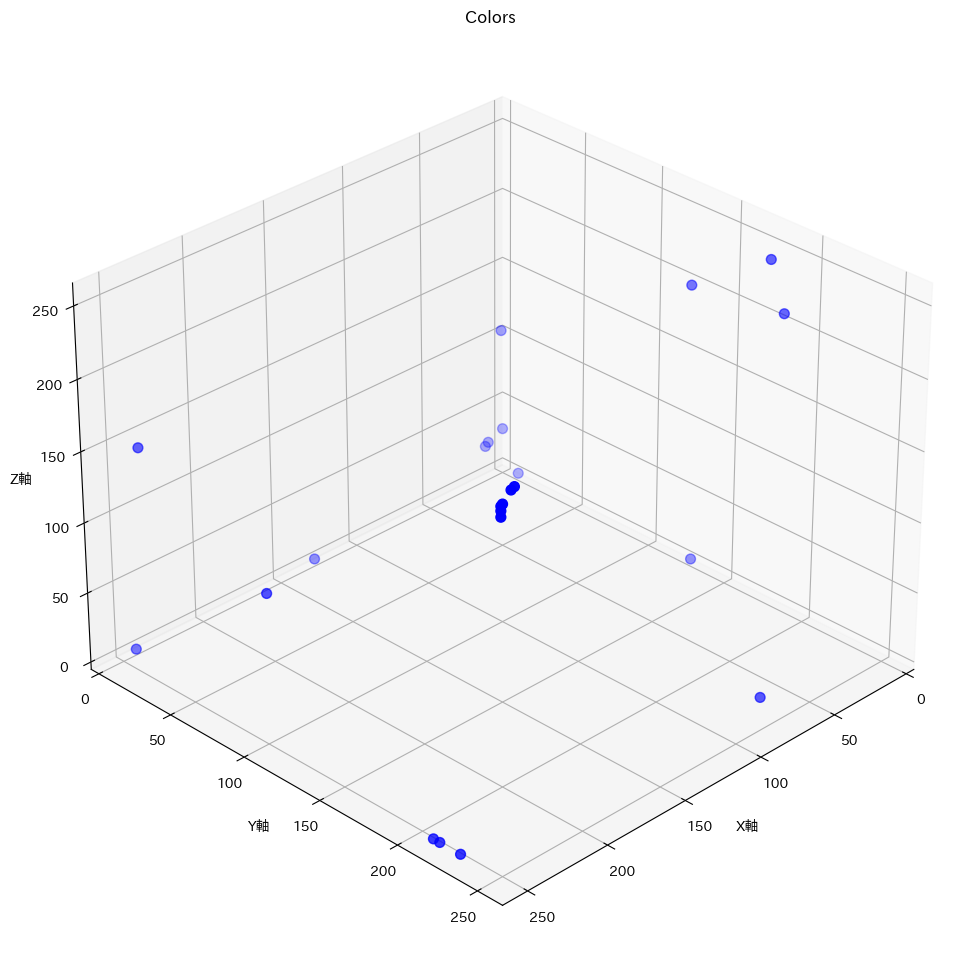

In [36]:
plot_colors(starting_origins)

In [37]:
# 重心なら？
starting_origins = [535,454,492]
for n in range(20):
    print(n+1,'回目')
    new_origins_by_centroid(starting_origins)

1 回目
R          255.0
G          255.0
B          251.0
名前    {白, white}
Name: 474, dtype: object
2 回目
R              243.0
G                1.0
B                0.0
名前    {hunting pink}
Name: 409, dtype: object
3 回目
R     255.0
G     254.0
B     249.0
名前    {胡粉色}
Name: 235, dtype: object
4 回目
R                0.0
G               11.0
B                0.0
名前    {烏羽色, 濡烏, 濡羽色}
Name: 377, dtype: object
5 回目
R                                255.0
G                                254.0
B                                246.0
名前    {乳白色, milky whiteミルク色, ミルキーホワイト}
Name: 375, dtype: object
6 回目
R       0.0
G       0.0
B      28.0
名前    {暗黒色}
Name: 58, dtype: object
7 回目
R      247.0
G      252.0
B      254.0
名前    {卯の花色}
Name: 101, dtype: object
8 回目
R     10.0
G      0.0
B     23.0
名前    {漆黒}
Name: 265, dtype: object
9 回目
R                           255.0
G                           254.0
B                           242.0
名前    {パールホワイト, pearl white, 真珠色}
Name: 280, dtype: object
10 回目
R    

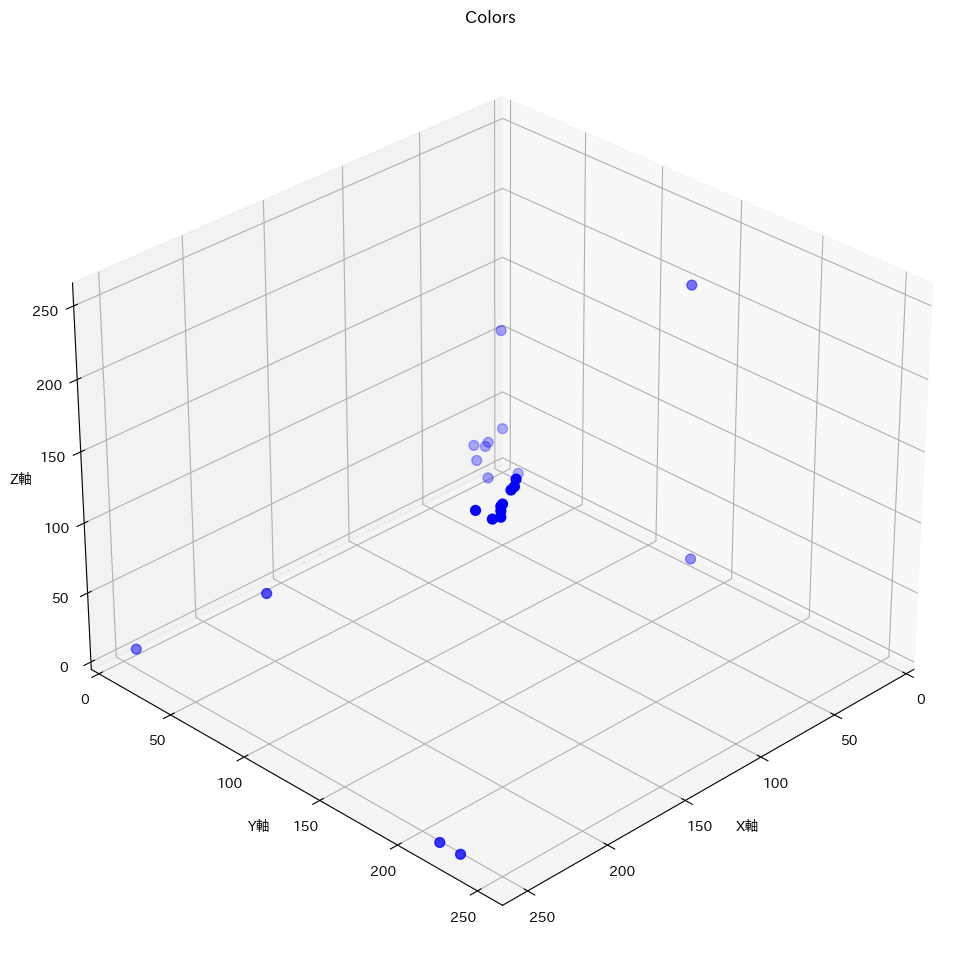

In [38]:
plot_colors(starting_origins)

In [39]:
# 半径のやつ
starting_origins = [535,454,492]
for n in range(15):
    print(n+1,'回目')
    new_origins_by_radius(starting_origins)

1 回目
R          255.0
G          255.0
B          251.0
名前    {白, white}
Name: 474, dtype: object
2 回目
R                0.0
G               11.0
B                0.0
名前    {烏羽色, 濡烏, 濡羽色}
Name: 377, dtype: object
3 回目
R     255.0
G     254.0
B     249.0
名前    {胡粉色}
Name: 235, dtype: object
4 回目
R                                255.0
G                                254.0
B                                246.0
名前    {乳白色, milky whiteミルク色, ミルキーホワイト}
Name: 375, dtype: object
5 回目
R      247.0
G      252.0
B      254.0
名前    {卯の花色}
Name: 101, dtype: object
6 回目
R                           255.0
G                           254.0
B                           242.0
名前    {パールホワイト, pearl white, 真珠色}
Name: 280, dtype: object
7 回目
R            244.0
G            251.0
B            254.0
名前    {snow white}
Name: 291, dtype: object
8 回目
R       0.0
G       0.0
B      28.0
名前    {暗黒色}
Name: 58, dtype: object
9 回目
R            240.0
G            248.0
B            255.0
名前    {Alice blue}
Name: 56, dt

100回で試行してみたった  

1 回目
R          255.0
G          255.0
B          251.0
名前    {白, white}
Name: 474, dtype: object
2 回目
R                0.0
G               11.0
B                0.0
名前    {濡羽色, 烏羽色, 濡烏}
Name: 377, dtype: object
3 回目
R     255.0
G     254.0
B     249.0
名前    {胡粉色}
Name: 235, dtype: object
4 回目
R                                255.0
G                                254.0
B                                246.0
名前    {乳白色, ミルキーホワイト, milky whiteミルク色}
Name: 375, dtype: object
5 回目
R      247.0
G      252.0
B      254.0
名前    {卯の花色}
Name: 101, dtype: object
6 回目
R                           255.0
G                           254.0
B                           242.0
名前    {パールホワイト, pearl white, 真珠色}
Name: 280, dtype: object
7 回目
R            244.0
G            251.0
B            254.0
名前    {snow white}
Name: 291, dtype: object
8 回目
R       0.0
G       0.0
B      28.0
名前    {暗黒色}
Name: 58, dtype: object
9 回目
R            240.0
G            248.0
B            255.0
名前    {Alice blue}
Name: 56, dtype: object
10 回目
R                255.0
G                249.0
B                238.0
名前    {生成色, off white}
Name: 130, dtype: object
11 回目
R     10.0
G      0.0
B     23.0
名前    {漆黒}
Name: 265, dtype: object
12 回目
R           13.0
G            1.0
B           22.0
名前    {黒, black}
Name: 452, dtype: object
13 回目
R     254.0
G     238.0
B     237.0
名前     {桜色}
Name: 245, dtype: object
14 回目
R      20.0
G       0.0
B      26.0
名前    {紫黒色}
Name: 263, dtype: object
15 回目
R              246.0
G              245.0
B              234.0
名前    {生成色, エクルベージュ}
Name: 175, dtype: object
16 回目
R               24.0
G                6.0
B               20.0
名前    {烏羽色, 濡烏, 濡羽色}
Name: 159, dtype: object
17 回目
R      255.0
G      246.0
B      220.0
名前    {鳥の子色}
Name: 362, dtype: object
18 回目
R         240.0
G         240.0
B         240.0
名前    {白, ホワイト}
Name: 277, dtype: object
19 回目
R     253.0
G     232.0
B     233.0
名前     {薄色}
Name: 84, dtype: object
20 回目
R     255.0
G     244.0
B     219.0
名前     {練色}
Name: 383, dtype: object
21 回目
R     255.0
G     239.0
B     207.0
名前    {薄卵色}
Name: 92, dtype: object
22 回目
R                                    237.0
G                                    240.0
B                                    224.0
名前    {牡蠣色, oyster white, 生牡蠣色, オイスターホワイト}
Name: 119, dtype: object
23 回目
R           254.0
G           227.0
B           215.0
名前    {baby pink}
Name: 464, dtype: object
24 回目
R                              243.0
G                              236.0
B                              216.0
名前    {象牙色, アイボリー, ivoryivory white}
Name: 8, dtype: object
25 回目
R                                        255.0
G                                        230.0
B                                        206.0
名前    {ペールオレンジ, 肌色, フレッシュ, flesh, pale orange}
Name: 455, dtype: object
26 回目
R             34.0
G             24.0
B             22.0
名前    {lamp black}
Name: 521, dtype: object
27 回目
R     230.0
G     231.0
B     232.0
名前    {灰白色}
Name: 141, dtype: object
28 回目
R     40.0
G     25.0
B     20.0
名前    {鉄黒}
Name: 348, dtype: object
29 回目
R                          1.0
G                          0.0
B                        102.0
名前    {濃青色, dark blue, ダークブルー}
Name: 312, dtype: object
30 回目
R            253.0
G            221.0
B            205.0
名前    {shell pink}
Name: 257, dtype: object
31 回目
R                     0.0
G                    31.0
B                    67.0
名前    {留紺, midnight blue}
Name: 491, dtype: object
32 回目
R                   255.0
G                   237.0
B                   179.0
名前    {cream yellowクリーム色}
Name: 187, dtype: object
33 回目
R     255.0
G     241.0
B     171.0
名前    {淡黄色}
Name: 324, dtype: object
34 回目
R         35.0
G         31.0
B         32.0
名前    {蝋色, 呂色}
Name: 538, dtype: object
35 回目
R           253.0
G           218.0
B           197.0
名前    {nail pink}
Name: 380, dtype: object
36 回目
R         255.0
G         232.0
B         175.0
名前    {leghorn}
Name: 534, dtype: object
37 回目
R            128.0
G              0.0
B              0.0
名前    {栗色, maroon}
Name: 485, dtype: object
38 回目
R                                          254.0
G                                          220.0
B                                          189.0
名前    {ペールオレンジ, 薄橙, 肌色, フレッシュジョンブリアン, フレッシュ, 肉色}
Name: 91, dtype: object
39 回目
R         15.0
G         26.0
B         69.0
名前    {鉄紺, 紺鉄}
Name: 241, dtype: object
40 回目
R                          244.0
G                          224.0
B                          196.0
名前    {亜麻色, écruecru beige, 生成色}
Name: 107, dtype: object
41 回目
R               202.0
G               232.0
B               226.0
名前    {秘色, セラドン, 青磁色}
Name: 420, dtype: object
42 回目
R          0.0
G         79.0
B         42.0
名前    {spruce}
Name: 292, dtype: object
43 回目
R     242.0
G     223.0
B     187.0
名前     {薄香}
Name: 88, dtype: object
44 回目
R           226.0
G           227.0
B           203.0
名前    {parchment}
Name: 387, dtype: object
45 回目
R     253.0
G     210.0
B     185.0
名前     {洗柿}
Name: 54, dtype: object
46 回目
R                        249.0
G                        193.0
B                        207.0
名前    {Chinese pink, ピンク, 石竹色}
Name: 302, dtype: object
47 回目
R                         171.0
G                         225.0
B                         250.0
名前    {淡青色, light blue, ライトブルー}
Name: 326, dtype: object
48 回目
R     40.0
G     41.0
B     40.0
名前    {黒橡}
Name: 200, dtype: object
49 回目
R       0.0
G      81.0
B      51.0
名前    {暗緑色}
Name: 61, dtype: object
50 回目
R         245.0
G         201.0
B         198.0
名前    {鴇色, 朱鷺色}
Name: 355, dtype: object
51 回目
R          250.0
G          199.0
B          193.0
名前    {朱華色, 唐棣色}
Name: 406, dtype: object
52 回目
R          42.0
G          42.0
B          42.0
名前    {黒, ブラック}
Name: 196, dtype: object
53 回目
R           204.0
G           231.0
B           211.0
名前    {ice green}
Name: 5, dtype: object
54 回目
R       206.0
G       197.0
B       240.0
名前    {サフラン色}
Name: 252, dtype: object
55 回目
R                         253.0
G                         209.0
B                         176.0
名前    {peach, ピーチ, ペッシュ, pêche}
Name: 415, dtype: object
56 回目
R     255.0
G     218.0
B     162.0
名前     {雄黄}
Name: 510, dtype: object
57 回目
R           0.0
G          89.0
B          49.0
名前    {深緑色, 深緑}
Name: 281, dtype: object
58 回目
R              232.0
G              218.0
B              190.0
名前    {エクルベージュ, 亜麻色}
Name: 49, dtype: object
59 回目
R     230.0
G     210.0
B     201.0
名前     {灰桜}
Name: 397, dtype: object
60 回目
R     13.0
G     42.0
B     82.0
名前    {濃藍}
Name: 208, dtype: object
61 回目
R           173.0
G           224.0
B           238.0
名前    {baby blue}
Name: 465, dtype: object
62 回目
R                0.0
G               87.0
B               57.0
名前    {bottle green}
Name: 470, dtype: object
63 回目
R     211.0
G     232.0
B     193.0
名前    {裏葉柳}
Name: 104, dtype: object
64 回目
R           95.0
G           22.0
B           29.0
名前    {bordeaux}
Name: 473, dtype: object
65 回目
R     163.0
G     216.0
B     246.0
名前     {白縹}
Name: 278, dtype: object
66 回目
R     205.0
G     230.0
B     199.0
名前     {白緑}
Name: 423, dtype: object
67 回目
R     235.0
G     225.0
B     169.0
名前    {蒸栗色}
Name: 498, dtype: object
68 回目
R                         255.0
G                         239.0
B                         108.0
名前    {canary yellow金糸雀色, 金絲雀色}
Name: 152, dtype: object
69 回目
R                        252.0
G                        241.0
B                        110.0
名前    {黄蘗色, chartreuse yellow}
Name: 176, dtype: object
70 回目
R      0.0
G     83.0
B     68.0
名前    {鉄色}
Name: 197, dtype: object
71 回目
R              243.0
G                1.0
B                0.0
名前    {hunting pink}
Name: 409, dtype: object
72 回目
R                           0.0
G                         174.0
B                         239.0
名前    {シアン, 藍紫色, cyancyan blue}
Name: 254, dtype: object
73 回目
R                  0.0
G                183.0
B                206.0
名前    {turquoise blue}
Name: 313, dtype: object
74 回目
R                                                 175.0
G                                                 223.0
B                                                 228.0
名前    {水縹, ウォーターブルー水縹, ウォーターブルー, water blue, アクア, aq...
Name: 33, dtype: object
75 回目
R             206.0
G             230.0
B             193.0
名前    {淡緑, 薄緑, 淡緑色}
Name: 99, dtype: object
76 回目
R                            106.0
G                             51.0
B                              0.0
名前    {chestnutchestnut brown, 栗色}
Name: 327, dtype: object
77 回目
R                   86.0
G                   27.0
B                   36.0
名前    {burgundy, ワインレッド}
Name: 386, dtype: object
78 回目
R                 255.0
G                 244.0
B                  80.0
名前    {lemon yellow檸檬色}
Name: 536, dtype: object
79 回目
R     255.0
G     229.0
B       0.0
名前     {中黄}
Name: 337, dtype: object
80 回目
R     75.0
G     45.0
B     28.0
名前    {黒茶}
Name: 198, dtype: object
81 回目
R     123.0
G      40.0
B       0.0
名前    {赤銅色}
Name: 268, dtype: object
82 回目
R                0.0
G               99.0
B               58.0
名前    {hunter green}
Name: 408, dtype: object
83 回目
R     246.0
G     186.0
B     188.0
名前    {薄紅梅}
Name: 89, dtype: object
84 回目
R          246.0
G          173.0
B          198.0
名前    {ピンク, 撫子色}
Name: 368, dtype: object
85 回目
R     35.0
G     39.0
B     79.0
名前    {青褐}
Name: 13, dtype: object
86 回目
R               247.0
G               173.0
B               195.0
名前    {cyclamen pink}
Name: 262, dtype: object
87 回目
R                   51.0
G                   49.0
B                   50.0
名前    {墨墨色, ivory black}
Name: 9, dtype: object
88 回目
R                              65.0
G                              20.0
B                              69.0
名前    {ペールオレンジ, 肌色, 紫根, 肉色, 紫紺, 宍色}
Name: 264, dtype: object
89 回目
R                            255.0
G                            216.0
B                              0.0
名前    {jaune brillant, 黄色, yellow}
Name: 62, dtype: object
90 回目
R     173.0
G     205.0
B     236.0
名前    {薄花桜}
Name: 97, dtype: object
91 回目
R      255.0
G      236.0
B       80.0
名前    {菜の花色}
Name: 369, dtype: object
92 回目
R                 255.0
G                 212.0
B                   0.0
名前    {イエロー, 黄黄色, 蒲公英色}
Name: 167, dtype: object
93 回目
R                0.0
G              107.0
B               62.0
名前    {chrome green}
Name: 202, dtype: object
94 回目
R               192.0
G               205.0
B               220.0
名前    {fountain blue}
Name: 433, dtype: object
95 回目
R     255.0
G     200.0
B       0.0
名前     {赤黄}
Name: 23, dtype: object
96 回目
R                           0.0
G                          72.0
B                         100.0
名前    {teal blue, 鴨の羽色ティールグリーン}
Name: 347, dtype: object
97 回目
R                31.0
G                47.0
B                84.0
名前    {navynavy blue}
Name: 378, dtype: object
98 回目
R                  0.0
G                 93.0
B                 77.0
名前    {billiard green}
Name: 426, dtype: object
99 回目
R        105.0
G         28.0
B         35.0
名前    {garnet}
Name: 139, dtype: object
100 回目
R          175.0
G            1.0
B           28.0
名前    {Deep red}
Name: 346, dtype: object

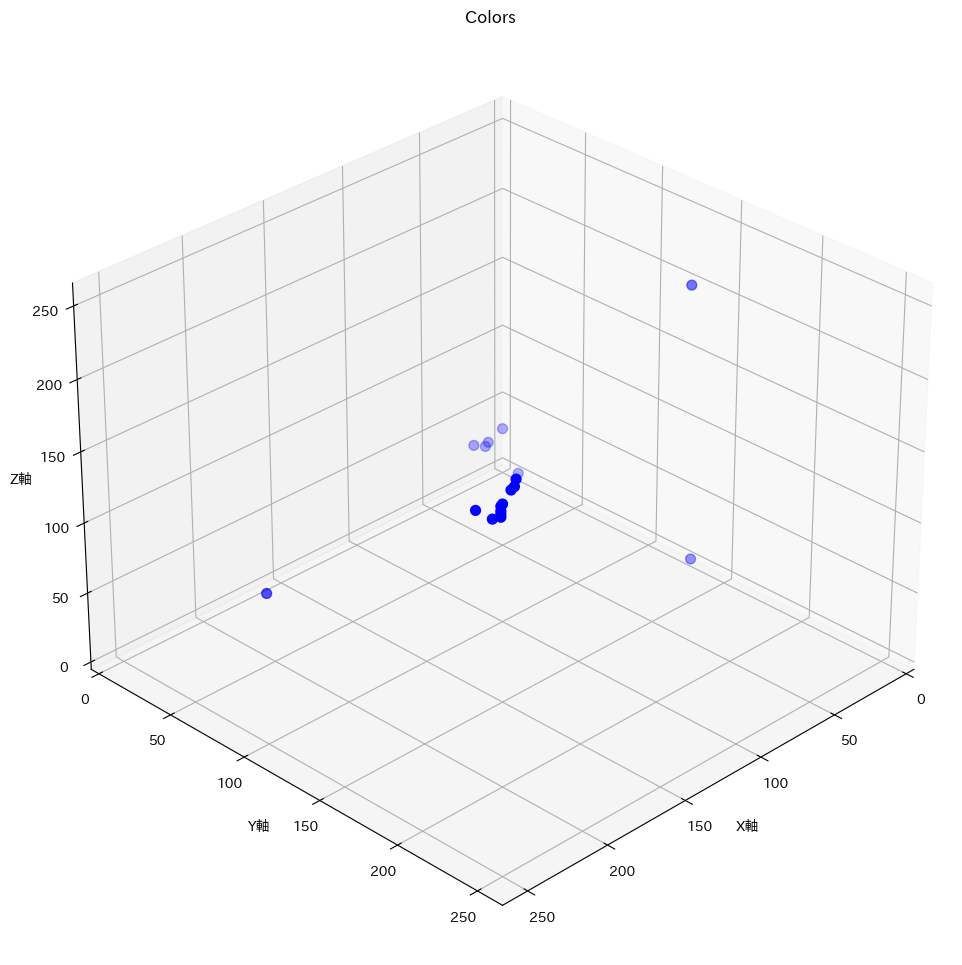

In [40]:
plot_colors(starting_origins)

In [41]:
new_rows = [{'R': 255, 'G': 0, 'B': 0, '名前':'Absolute R' },
          {'R': 0, 'G': 255, 'B': 0, '名前':'Absolute G' },
          {'R': 0, 'G': 0, 'B': 255, '名前':'Absolute B' }]
for row in new_rows:
    df.loc[len(df)] = row

In [42]:
# 和で最遠点を定義して何回か追加したらどうなるか
starting_origins = [554,555,556]
for n in range(20):
    print(n+1,'回目')
    new_origins_by_sum(starting_origins)

1 回目
R          255.0
G          255.0
B          251.0
名前    {白, white}
Name: 474, dtype: object
2 回目
R                0.0
G               11.0
B                0.0
名前    {烏羽色, 濡烏, 濡羽色}
Name: 377, dtype: object
3 回目
R     255.0
G     254.0
B     249.0
名前    {胡粉色}
Name: 235, dtype: object
4 回目
R     255.0
G     229.0
B       0.0
名前     {中黄}
Name: 337, dtype: object
5 回目
R                           0.0
G                         174.0
B                         239.0
名前    {cyancyan blue, 藍紫色, シアン}
Name: 254, dtype: object
6 回目
R              243.0
G                1.0
B                0.0
名前    {hunting pink}
Name: 409, dtype: object
7 回目
R       0.0
G       0.0
B      28.0
名前    {暗黒色}
Name: 58, dtype: object
8 回目
R      247.0
G      252.0
B      254.0
名前    {卯の花色}
Name: 101, dtype: object
9 回目
R                            255.0
G                            216.0
B                              0.0
名前    {jaune brillant, 黄色, yellow}
Name: 62, dtype: object
10 回目
R                         

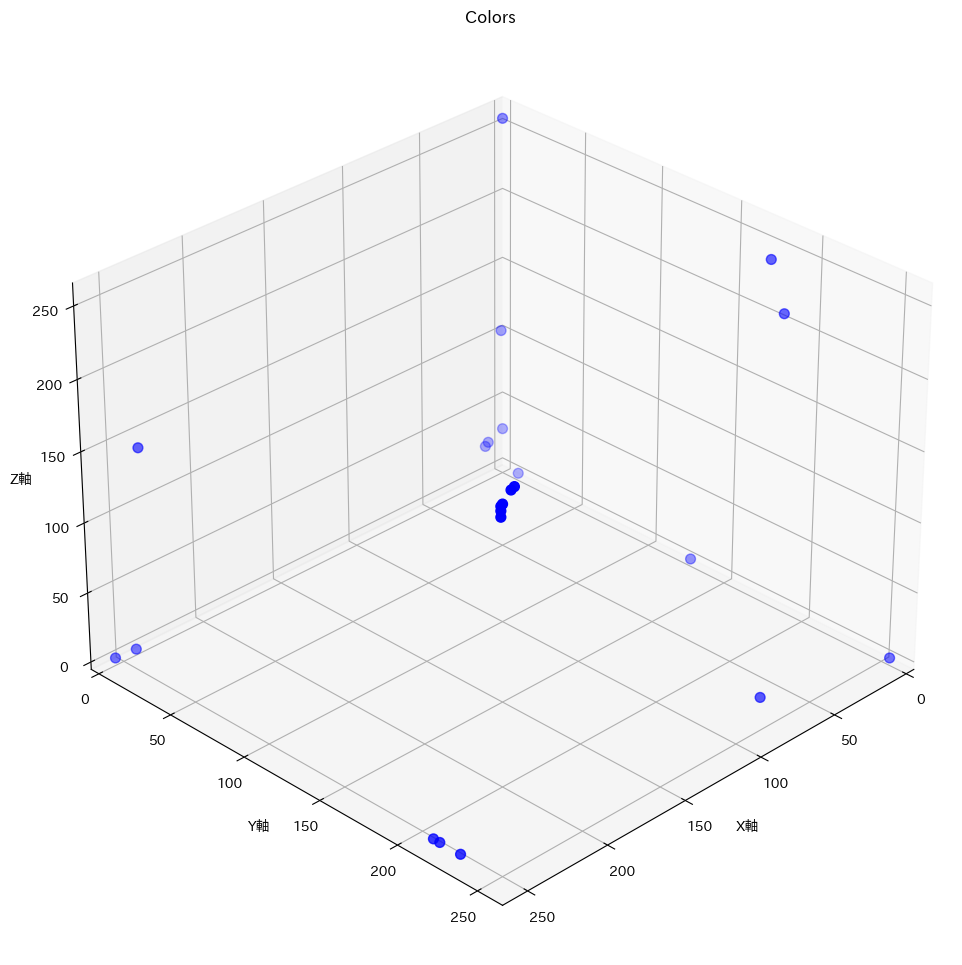

In [43]:
plot_colors(starting_origins)

In [44]:
# 重心で最遠点を定義して何回か追加したらどうなるか
starting_origins = [554,555,556]
for n in range(20):
    print(n+1,'回目')
    new_origins_by_centroid(starting_origins)

1 回目
R          255.0
G          255.0
B          251.0
名前    {白, white}
Name: 474, dtype: object
2 回目
R     255.0
G     254.0
B     249.0
名前    {胡粉色}
Name: 235, dtype: object
3 回目
R                0.0
G               11.0
B                0.0
名前    {烏羽色, 濡烏, 濡羽色}
Name: 377, dtype: object
4 回目
R                                255.0
G                                254.0
B                                246.0
名前    {乳白色, milky whiteミルク色, ミルキーホワイト}
Name: 375, dtype: object
5 回目
R       0.0
G       0.0
B      28.0
名前    {暗黒色}
Name: 58, dtype: object
6 回目
R              243.0
G                1.0
B                0.0
名前    {hunting pink}
Name: 409, dtype: object
7 回目
R      247.0
G      252.0
B      254.0
名前    {卯の花色}
Name: 101, dtype: object
8 回目
R     10.0
G      0.0
B     23.0
名前    {漆黒}
Name: 265, dtype: object
9 回目
R                           255.0
G                           254.0
B                           242.0
名前    {パールホワイト, pearl white, 真珠色}
Name: 280, dtype: object
10 回目
R    

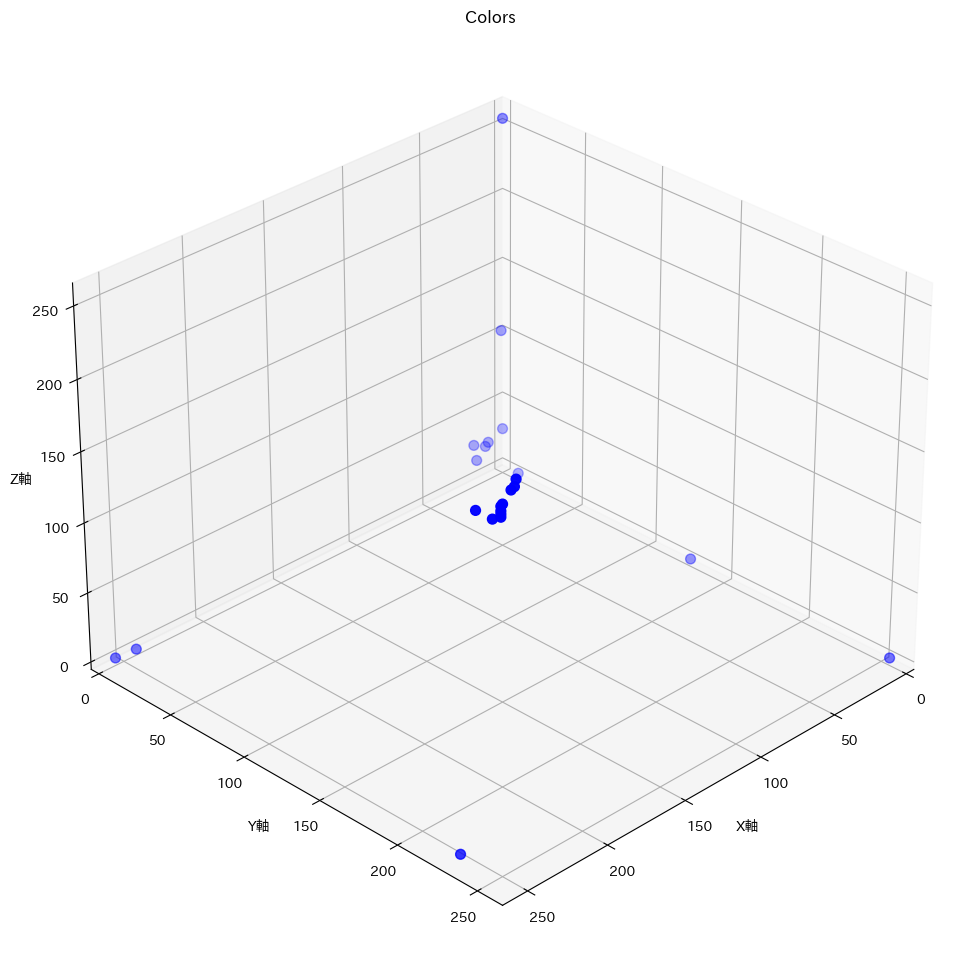

In [45]:
plot_colors(starting_origins)

In [46]:
# 半径のやつ
starting_origins = [554,555,556]
for n in range(15):
    print(n+1,'回目')
    new_origins_by_radius(starting_origins)

1 回目
R     255.0
G     229.0
B       0.0
名前     {中黄}
Name: 337, dtype: object
2 回目
R                            255.0
G                            216.0
B                              0.0
名前    {jaune brillant, 黄色, yellow}
Name: 62, dtype: object
3 回目
R                 255.0
G                 212.0
B                   0.0
名前    {蒲公英色, 黄黄色, イエロー}
Name: 167, dtype: object
4 回目
R     255.0
G     200.0
B       0.0
名前     {赤黄}
Name: 23, dtype: object
5 回目
R     244.0
G     229.0
B      17.0
名前     {青黄}
Name: 14, dtype: object
6 回目
R               255.0
G               203.0
B                 5.0
名前    {chrome yellow}
Name: 201, dtype: object
7 回目
R               255.0
G               196.0
B                12.0
名前    {Mikado Yellow}
Name: 488, dtype: object
8 回目
R      255.0
G      194.0
B       14.0
名前    {向日葵色}
Name: 421, dtype: object
9 回目
R                 255.0
G                 244.0
B                  80.0
名前    {lemon yellow檸檬色}
Name: 536, dtype: object
10 回目
R                      

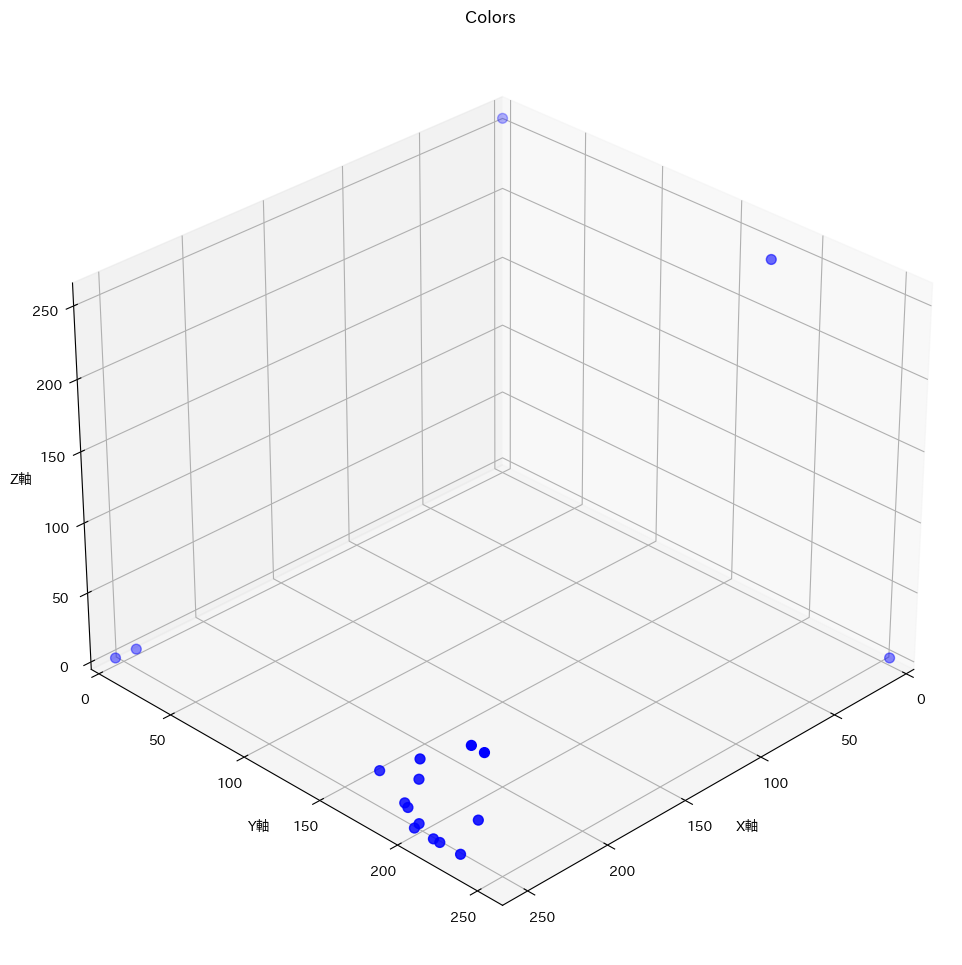

In [47]:
plot_colors(starting_origins)